In [1]:
_server_root = ""
_data_uuid = ""
_result_path = ""

In [2]:
# Parameters
_server_root = "/home/lyiran/neelptycho/server"
_data_uuid = "5196cdfa-f52f-5d43-b8d6-a8e15befdebe"
_result_path = "/home/lyiran/neelptycho/server/results/task_SimpleSimScikit2_PtyPy_DM_padding_2_full_support"


In [3]:
import uuid
data_uuid = uuid.UUID(_data_uuid)
from pathlib import Path
result_path = Path(_result_path)
import sys, os
sys.path.append(_server_root)

In [4]:
# Timer
import time
start_time = time.time()

## PtyPy Analysis

In [5]:
from library.data import get_data_path
from library.utils import load_params, add_colordisk_hsv, complex_to_hsv, check_path, with_default_unit
import h5py
import tables
data_path = get_data_path(data_uuid)
p = load_params("PtyPy")
with h5py.File(data_path, "r") as file:
    attrs = dict(file.attrs)
    dshape = file["data"].shape[-2:]

if "semiconv_pix" in p:
    attrs["semiconv_pix"] = p["semiconv_pix"]
    del p["semiconv_pix"]
if "rotation" in p:
    attrs["rotation"] = with_default_unit(p["rotation"], "degree")
    del p["rotation"]

defocus = 0
if "defocus" in p:
    defocus = with_default_unit(p["defocus"], "m")
    del p["defocus"]
distance = attrs["semiconv_pix"] * attrs["psize"] / attrs["semiconv"]

probe_diameter = 1e-10
if "probe_diameter" in p:
    probe_diameter = with_default_unit(p["probe_diameter"], "m")
    del p["probe_diameter"]

assert "scans" in p
assert "scan_00" in p["scans"]
assert "engines" in p

## Showing Parameters

In [6]:
import pint
ureg = pint.UnitRegistry()
ureg.default_format = "P~"
Q_ = ureg.Quantity

from scipy import constants
def C_(name: str):
    return Q_(constants.value(name), constants.unit(name))
h = C_("Planck constant")
c = C_("speed of light in vacuum")
m_e = C_("electron mass")
e = C_("elementary charge")

import numpy as np

In [7]:
# experimental parameters
convergence_semiangle = Q_(attrs["semiconv"], "rad")/ureg.rad # radian usually ignored
convergence_semiangle_in_pixel = Q_(attrs["semiconv_pix"], "pixel")

#detector_distance = Q_(13.5, "meter")
detector_pixel_size = Q_(attrs["psize"], "meter/pixel")
detector_dimension = dshape[0]
detector_distance = convergence_semiangle_in_pixel * detector_pixel_size / convergence_semiangle
#convergence_semiangle_in_pixel = detector_distance * convergence_semiangle / detector_pixel_size

acceleration_voltage = Q_(attrs["voltage"], "kV")
wavelength = np.sqrt(
    ((h**2 * c**2)/
    (e*acceleration_voltage*(2*m_e*c**2 + e*acceleration_voltage)))).to("meter")
wavelength

4.175716077283419e-12 <Unit('meter')>

In [8]:
# modified parameters
detector_rebin_factor = p.scans.scan_00.data.get("rebin", 1)
padding_factor = (sum(p.scans.scan_00.data.get("padding", [0,0,0,0]))/2 + dshape[0]) / dshape[0]

detector_pixel_size_rebinned = detector_pixel_size * detector_rebin_factor
detector_dimension_rebinned_padded = detector_dimension / detector_rebin_factor * padding_factor
convergence_semiangle_in_pixel_rebinned = convergence_semiangle_in_pixel / detector_rebin_factor

In [9]:
# reconstructed parameters
resolution_reciprocal_space_rad = convergence_semiangle*ureg.rad / convergence_semiangle_in_pixel_rebinned
resolution_reciprocal_space = convergence_semiangle/(wavelength*convergence_semiangle_in_pixel_rebinned)
resolution_real_space = 1/(resolution_reciprocal_space*Q_(detector_dimension_rebinned_padded, "pixel"))/ureg.pixel
size_real_space = 1/resolution_reciprocal_space/ureg.pixel
real_space_dimension = size_real_space/resolution_real_space

In [10]:
# based on experimental parameters
real_space_sampling = Q_(attrs["stepsize"], "m")
real_space_probe_diameter = Q_(probe_diameter, "m")
alpha = (real_space_sampling/real_space_probe_diameter).to("")

Shannon_sampling = 2*constants.pi / real_space_probe_diameter
#beta = (2*constants.pi*resolution_reciprocal_space * ureg.pixel/Shannon_sampling).to("")
beta = (detector_pixel_size * real_space_probe_diameter / (wavelength * detector_distance) * ureg.pixel).to("")

In [11]:
print(f"Raw Data Parameters")
print(f"  Convergence Semi-Angle:         {convergence_semiangle.to('mrad')}")
print(f"  Acceleration Voltage:           {acceleration_voltage.to('kV')}")
print(f"  Detector Distance:              {detector_distance.to('m')}")
print(f"  Detector Dimension:             {detector_dimension}")
print(f"  Detector Pixel Size:            {detector_pixel_size.to('um/pixel')}")
print(f"  Pixel Size of Transmitted Disk: {convergence_semiangle_in_pixel.to('pixel')} (Radius)")
print(f"")
print(f"Ptychography Reconstruction Parameters")
print(f"  Detector Binning Factor:        {detector_rebin_factor}")
print(f"  Detector Padding Factor:        {padding_factor}")
print(f"  Reciprocal Space Resolution:    {resolution_reciprocal_space_rad.to('rad/pixel')}")
print(f"  Reciprocal Space Resolution:    {resolution_reciprocal_space.to('angstrom^-1/pixel')}")
print(f"  Real Space Resolution:          {resolution_real_space.to('angstrom/pixel')}")
print(f"  Real Space Size:                {size_real_space.to('angstrom')}")
print(f"  Real Space Dimension:           {real_space_dimension}")
print(f"")
print(f"Sampling Criteria")
print(f"  Real Sampling (R):              {real_space_sampling}")
print(f"  Real Space Probe Diameter (D):  {real_space_probe_diameter}")
print(f"  alpha (R/D) (should be < 1):    {alpha}")
print(f"  Reciprocal Sampling (Q):        {(resolution_reciprocal_space * ureg.pixel).to('1/m')}")
print(f"  Shannon Sampling (q):           {Shannon_sampling.to('1/m')}")
print(f"  beta (Q/q) (should be < 1):     {beta}")
print(f"  1/(alpha*beta) (should be > 2): {1/(alpha*beta)}")

Raw Data Parameters
  Convergence Semi-Angle:         20.0 mrad
  Acceleration Voltage:           80 kV
  Detector Distance:              0.033714999999999995 m
  Detector Dimension:             128
  Detector Pixel Size:            55.0 µm/pixel
  Pixel Size of Transmitted Disk: 12.26 pixel (Radius)

Ptychography Reconstruction Parameters
  Detector Binning Factor:        1
  Detector Padding Factor:        2.0
  Reciprocal Space Resolution:    0.0016313213703099511 rad/pixel
  Reciprocal Space Resolution:    0.03906686518234818 1/pixel/Å
  Real Space Resolution:          0.09998882638182563 Å/pixel
  Real Space Size:                25.59713955374736 Å
  Real Space Dimension:           256.0 pixel

Sampling Criteria
  Real Sampling (R):              1×10⁻¹⁰ m
  Real Space Probe Diameter (D):  1×10⁻¹⁰ m
  alpha (R/D) (should be < 1):    1.0
  Reciprocal Sampling (Q):        390668651.82348174 1/m
  Shannon Sampling (q):           62831853071.79586 1/m
  beta (Q/q) (should be < 1):     

---

In [12]:
import ptypy
import ptypy.utils as u
from ptypy.custom import ThreePIE
from ptypy.core import xy
from os.path import relpath
ptypy.load_ptyscan_module("hdf5_loader")

try:
    ptypy.load_gpu_engines("cuda")
except:
    pass

check_path(p, "io")
#p.io.rfile = str(result_path/"recons"/"%(run)s_%(engine)s_%(iterations)04d.ptyr")
p.io.rfile = relpath(str(result_path/"recons"/"%(run)s_%(engine)s_%(iterations)04d.ptyr"), os.getcwd())

check_path(p.io, "autoplot")
p.io.autoplot.active = False

check_path(p.io, "autosave")
#p.io.autosave.rfile = str(result_path/"dumps"/"%(run)s/%(run)s_%(engine)s_%(iterations)04d.ptyr")
p.io.autosave.rfile = relpath(str(result_path/"dumps"/"%(run)s/%(run)s_%(engine)s_%(iterations)04d.ptyr"), os.getcwd())

check_path(p.scans.scan_00, "data")
p.scans.scan_00.data.electron_data = True
p.scans.scan_00.data.energy = float(attrs["voltage"])
p.scans.scan_00.data.psize = attrs["psize"]
p.scans.scan_00.data.distance = distance
check_path(p.scans.scan_00, "illumination")
p.scans.scan_00.illumination.model = None
p.scans.scan_00.illumination.photons = None

check_path(p.scans.scan_00.illumination, "aperture")
p.scans.scan_00.illumination.aperture.form = "circ"
p.scans.scan_00.illumination.aperture.size = distance * attrs["semiconv"] * 2 # in diameter

check_path(p.scans.scan_00.illumination, "propagation")
p.scans.scan_00.illumination.propagation.focussed = distance #- defocus
p.scans.scan_00.illumination.propagation.parallel = -defocus if defocus != 0 else None

check_path(p.scans.scan_00, "data")
p.scans.scan_00.data.name = "Hdf5Loader"
p.scans.scan_00.data.orientation = 2
p.scans.scan_00.data.intensities = u.Param()
p.scans.scan_00.data.intensities.file = str(data_path)
p.scans.scan_00.data.intensities.key = "data"
p.scans.scan_00.data.positions = u.Param()
p.scans.scan_00.data.positions.file = "positions"
p.scans.scan_00.data.positions.slow_key = "pos_y"
p.scans.scan_00.data.positions.slow_multiplier = 1
p.scans.scan_00.data.positions.file = "positions"
p.scans.scan_00.data.positions.fast_key = "pos_x"
p.scans.scan_00.data.positions.fast_multiplier = 1

nx = attrs["width"]
ny = attrs["height"]
#p.scans.scan_00.data.positions_theory = xy.raster_scan(ny=nx, nx=ny, dy=attrs["stepsize"], dx=attrs["stepsize"], ang=90)
print(p)

* id3VH8E3UAS0           : ptypy.utils.parameters.Param(4)
  * frames_per_block     : 1024
  * io                   : ptypy.utils.parameters.Param(3)
    * autosave           : ptypy.utils.parameters.Param(3)
      * active           : True
      * interval         : 10
      * rfile            : ../../results/task_SimpleSimScikit2_PtyPy_DM_padding_
    * rfile              : ../../results/task_SimpleSimScikit2_PtyPy_DM_padding_
    * autoplot           : ptypy.utils.parameters.Param(1)
      * active           : False
  * scans                : ptypy.utils.parameters.Param(1)
    * scan_00            : ptypy.utils.parameters.Param(3)
      * name             : BlockFull
      * data             : ptypy.utils.parameters.Param(9)
        * electron_data  : True
        * padding        : list(4)= [64, 64, 64, 64]
        * energy         : 80.0
        * psize          : 5.5e-05
        * distance       : 0.033714999999999995
        * name           : Hdf5Loader
        * orientation  

In [13]:
nx = attrs["width"]
ny = attrs["height"]
with h5py.File("positions", "w") as file:
    if 'stepsize_y' in attrs:
        positions = xy.raster_scan(ny=nx, nx=ny, dy=attrs["stepsize"], dx=attrs["stepsize_y"], ang=90-attrs["rotation"])
    else:
        positions = xy.raster_scan(ny=nx, nx=ny, dy=attrs["stepsize"], dx=attrs["stepsize"], ang=90-attrs["rotation"])
    file.create_dataset("pos_x", shape=positions.shape[0])
    file.create_dataset("pos_y", shape=positions.shape[0])
    file["pos_x"][:] = positions[:,0]
    file["pos_y"][:] = positions[:,1]

In [14]:
import numpy as np

P = ptypy.core.Ptycho(p, level=2)

# Initialize the probe and object
if os.path.exists('probe_init.npy'):
    probe_init = np.load('probe_init.npy')
    P.probe.fill(probe_init)
if os.path.exists('object_init.npy'):
    object_init = np.load('object_init.npy')
    P.obj.fill(object_init)

P.init_communication()
P.init_engine()

# Run the reconstruction
P.run()
P.finalize()

Server listens on tcp://127.0.0.1, port 5560


stop listening on tcp://127.0.0.1, port 5560
==== This reconstruction relied on the following work ==========================
The Ptypy framework:
    Enders B. and Thibault P., "A computational framework for ptychographic reconstructions" Proc. Royal Soc. A 472 (2016) 20160640, doi: 10.1098/rspa.2016.0640.
The difference map reconstruction algorithm:
    Thibault et al., "Probe retrieval in ptychographic coherent diffractive imaging" Ultramicroscopy 109 (2009) 338, doi: 10.1016/j.ultramic.2008.12.011.


In [15]:
print(f"--- {time.time() - start_time} seconds ---")

--- 400.56178641319275 seconds ---


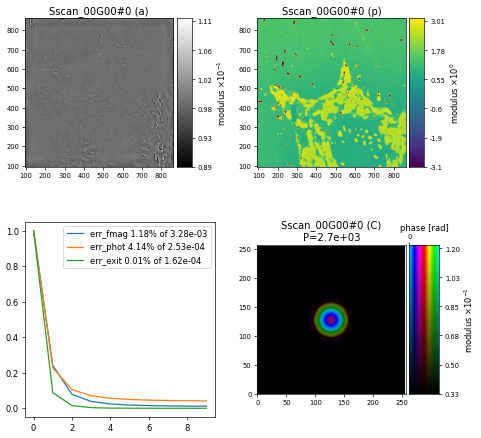

In [16]:
fig = ptypy.utils.plot_client.figure_from_ptycho(P)

## Plot and save the results

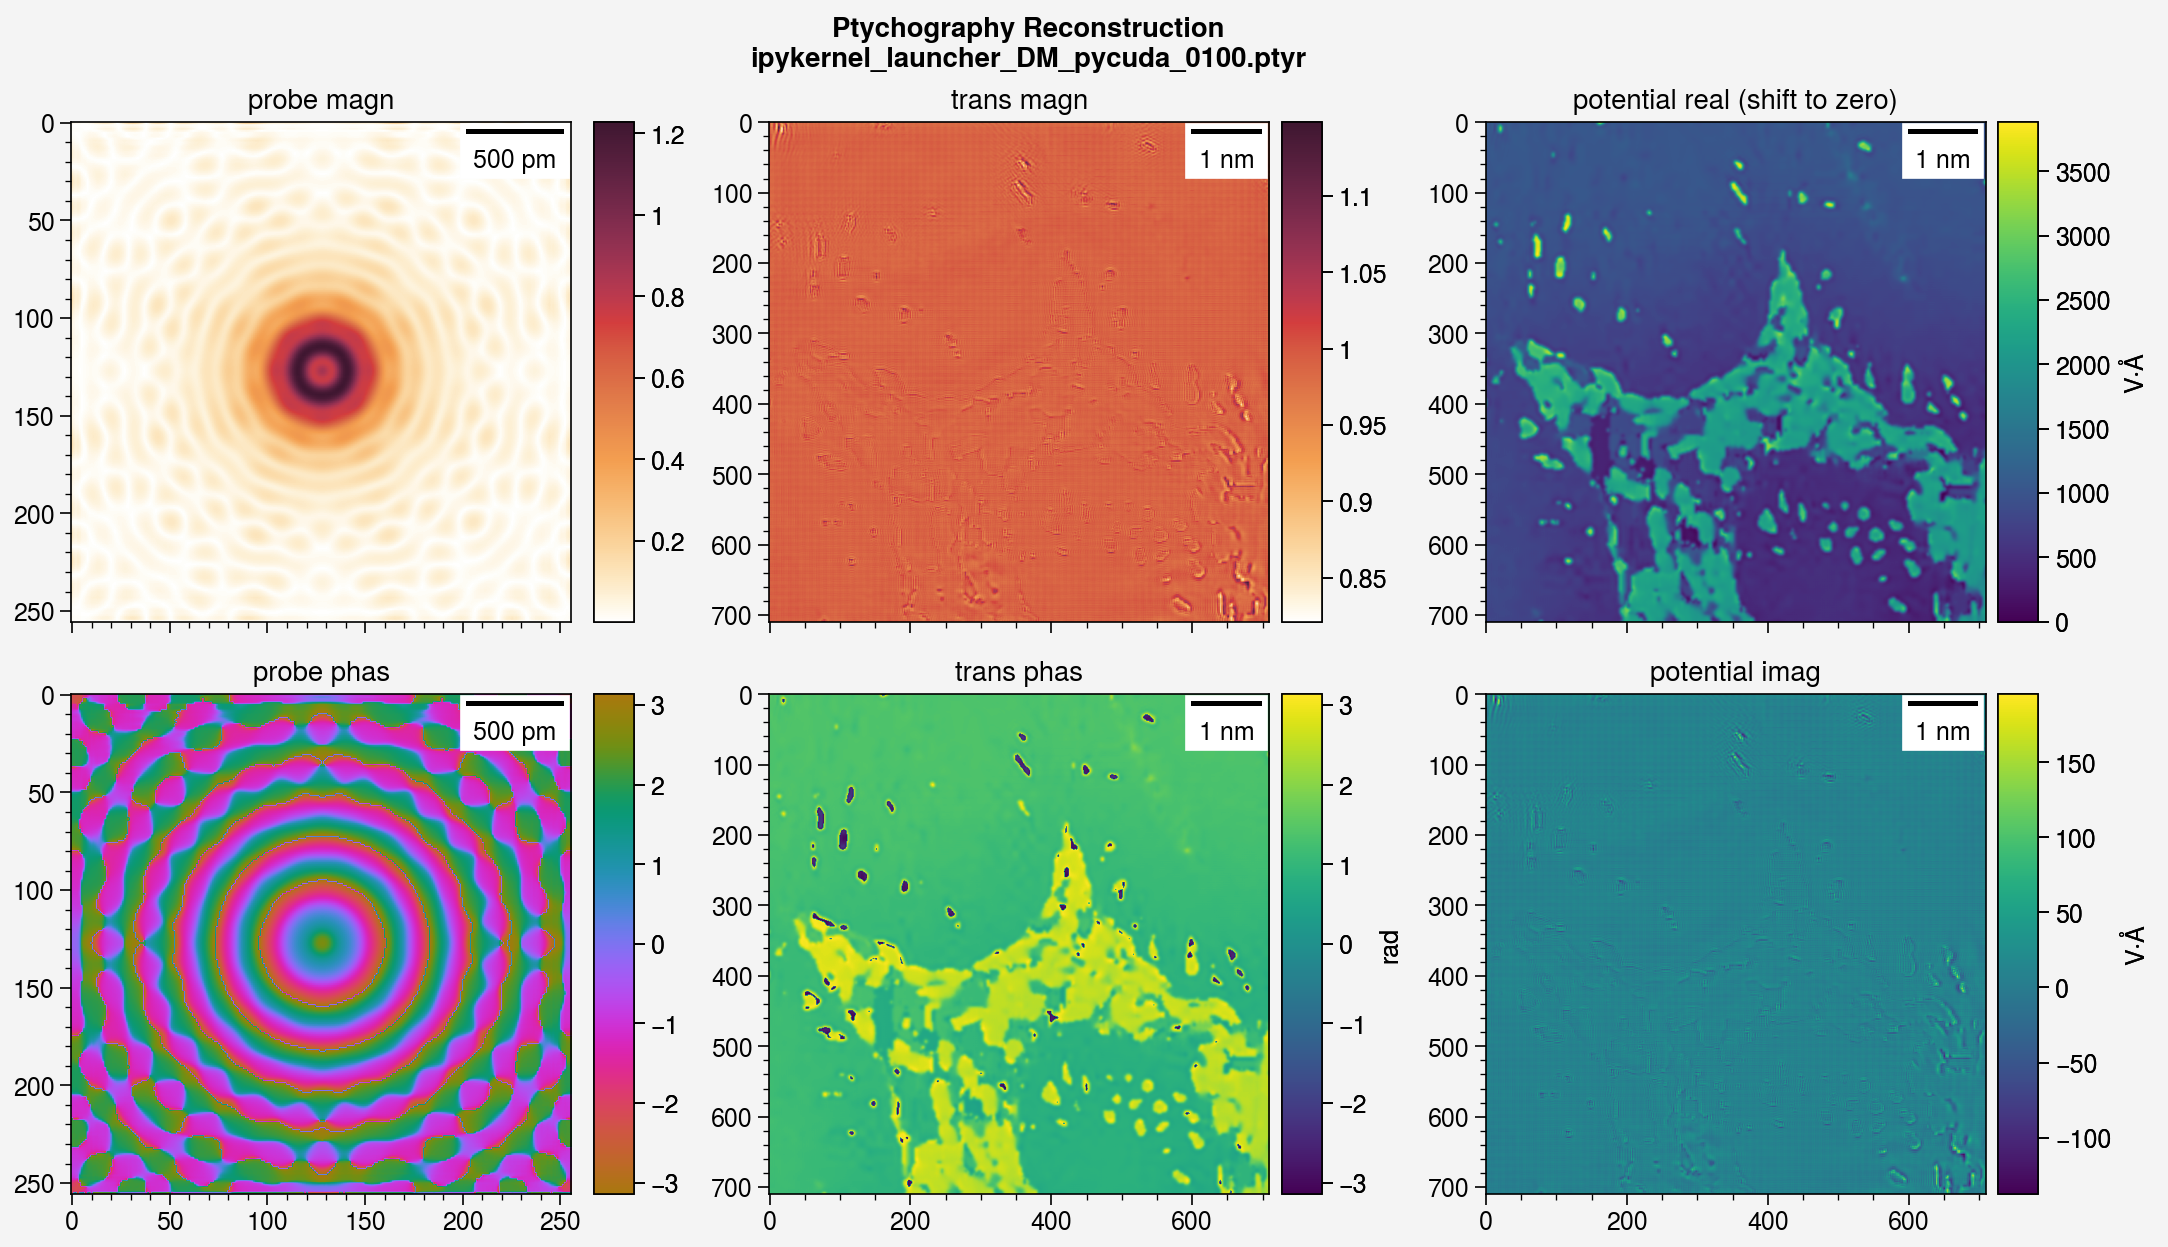

In [17]:
import numpy as np
from scipy import ndimage
from glob import glob
from library.utils import crop_image, sigma_e
from skimage.restoration import unwrap_phase

import matplotlib.pyplot as plt
from matplotlib import colors
import proplot as pplt
from matplotlib_scalebar.scalebar import ScaleBar
pplt.rc["grid"] = False

for filename in glob(str(result_path/"recons"/"*.ptyr")):
    f_basename = os.path.basename(filename)
    niter = f_basename[-9:-5]

    with h5py.File(filename, "r") as file:
        psize = file["/content/obj/Sscan_00G00/_psize"][0]
        transmission = np.flipud(file["/content/obj/Sscan_00G00/data"][0,:])
        probe = np.flipud(file["/content/probe/Sscan_00G00/data"][0,:])

    probe_rot = ndimage.rotate(probe, angle=-attrs["rotation"])
    trans_rot = crop_image(transmission,
                        size=(attrs["width"]*attrs["stepsize"], attrs["height"]*attrs["stepsize"]),
                        calibrations=psize,
                        angle=-attrs["rotation"])

    potential_real = unwrap_phase(np.angle(trans_rot))/sigma_e(accl=attrs["voltage"])
    potential_imag = -np.log(np.absolute(trans_rot)) / sigma_e(accl=attrs["voltage"])
    potential = potential_real + 1j * potential_imag

    fig, axs = pplt.subplots(nrows=2, ncols=3, sharey=False, suptitle=f"Ptychography Reconstruction\n{f_basename}")

    # probe image (magnitude and phase parts)
    m = axs[0, 0].imshow(np.abs(probe_rot) + 1e-3) #, norm=colors.LogNorm())
    axs[0, 0].format(title="probe magn")
    axs[0, 0].colorbar(m, loc="r")

    m = axs[1, 0].imshow(np.angle(probe_rot), cmap="phase", vmin=-np.pi, vmax=np.pi)
    axs[1, 0].format(title="probe phas")
    axs[1, 0].colorbar(m, loc="r")

    # transmission function (magnitude and phase parts)
    m = axs[0, 1].imshow(np.abs(trans_rot))
    axs[0, 1].format(title="trans magn")
    axs[0, 1].colorbar(m, loc="r")

    m = axs[1, 1].imshow(np.angle(trans_rot), cmap="viridis")
    axs[1, 1].format(title="trans phas")
    axs[1, 1].colorbar(m, loc="r", label="rad")

    # potential function (real and imaginary parts)
    m = axs[0, 2].imshow((potential_real - potential_real.min()) * 1e10, cmap="viridis")
    axs[0, 2].format(title="potential real (shift to zero)")
    axs[0, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

    m = axs[1, 2].imshow(potential_imag * 1e10, cmap="viridis")
    axs[1, 2].format(title="potential imag")
    axs[1, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

    for i in range(2):
        for j in range(3):
            axs[i, j].add_artist(ScaleBar(resolution_real_space.to('m/pixel').m, "m", length_fraction=0.2))

    pplt.show()
    fig.savefig(result_path/f"overview_{niter}.png")

    # save the results
    np.save(result_path/f"final_probe_rot_{niter}.npy", probe_rot)
    np.save(result_path/f"final_trans_rot_{niter}.npy", trans_rot)
    np.save(result_path/f"final_poten_rot_{niter}.npy", potential)

## Fit Aberration in Probe Wave Function

In [18]:
from fitaber import fit_aber, coefs_all_up_to
import fitaber

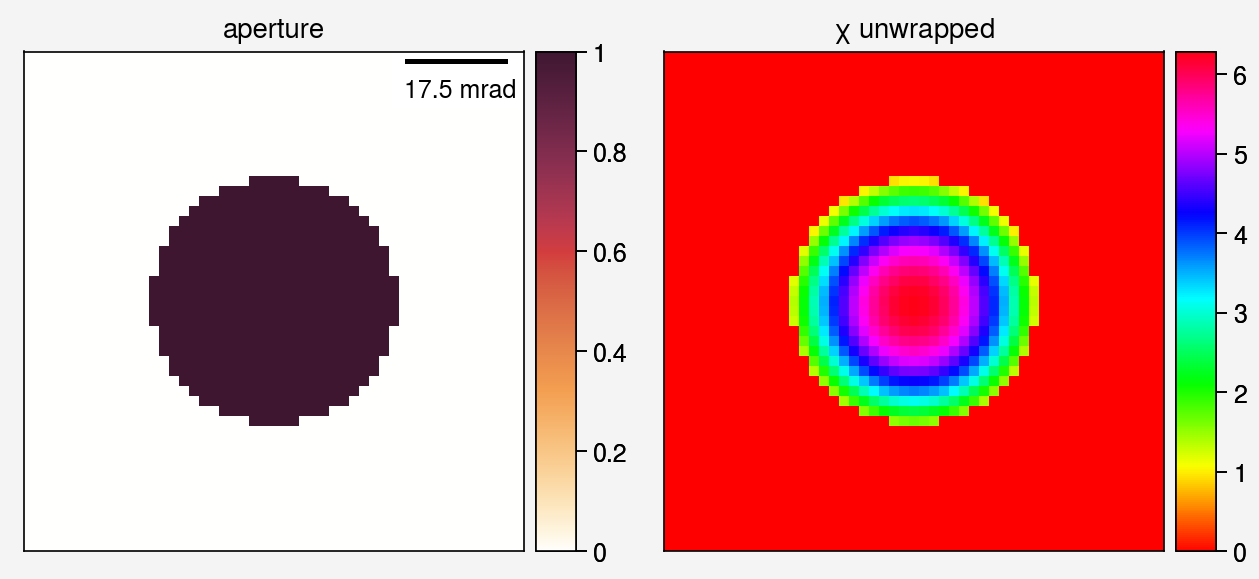

In [19]:
aperture = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot))))
aperture = (aperture > aperture.max()/2).astype(np.int32)
# chi = -np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture
chi = -unwrap_phase(np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture, wrap_around=True) * aperture

margin = aperture.shape[0]/2 - np.sum(aperture[aperture.shape[0]//2,:])
fig, (ax1, ax2) = pplt.subplots(nrows=1, ncols=2,
                                xlim=(margin, chi.shape[1]-margin),
                                ylim=(margin, chi.shape[1]-margin),
                                xticks=[], yticks=[])
m = ax1.imshow(aperture)
ax1.add_artist(ScaleBar(resolution_reciprocal_space_rad.to('rad/pixel').m,
                        units="deg", dimension="angle", length_fraction=0.25,
                        scale_formatter=lambda value, unit: f"{value*np.pi/180*1e3: .1f} mrad"))
ax1.colorbar(m, loc="r")
ax1.format(title="aperture")

m = ax2.imshow(chi, cmap="hsv")
ax2.colorbar(m, loc="r")
ax2.format(title="$\chi$ unwrapped")

In [20]:
result_aber = fit_aber(chi, coefs_all_up_to(), scale=resolution_reciprocal_space_rad.to('rad/pixel').m, mask=aperture, kV=attrs["voltage"])
print(result_aber.format())

[
[ 0]:      -: c(0,0) = C(-1,0)= Polar(  0.004178 nm,          0 °)
[ 1]:     A0: c(1,1) = C(0,1) = Polar(  0.009947 nm,     -179.1 °)
[ 3]:     C1: c(2,0) = C(1,0) = Polar(     17.03 nm,        180 °)
[ 4]:     A1: c(2,2) = C(1,2) = Polar(   0.01348 nm,     -3.742 °)
[ 6]: 1/3 B2: c(3,1) = C(2,1) = Polar(     12.14 nm,      28.99 °)
[ 8]:     A2: c(3,3) = C(2,3) = Polar(     0.603 nm,      17.95 °)
[10]:     C3: c(4,0) = C(3,0) = Polar(    0.3068 um,        180 °)
[11]: 1/4 S3: c(4,2) = C(3,2) = Polar(    0.1417 um,      51.79 °)
[13]:     A3: c(4,4) = C(3,4) = Polar(   0.01069 um,     -13.95 °)
[15]: 1/5 B4: c(5,1) = C(4,1) = Polar(     53.22 um,     -147.8 °)
[17]: 1/5 D4: c(5,3) = C(4,3) = Polar(     3.864 um,      57.86 °)
[19]:     A4: c(5,5) = C(4,5) = Polar(    0.8029 um,      5.023 °)
[21]:     C5: c(6,0) = C(5,0) = Polar(    0.9639 mm,          0 °)
[22]: 1/6 S5: c(6,2) = C(5,2) = Polar(    0.4582 mm,      -44.3 °)
[24]: 1/6 R5: c(6,4) = C(5,4) = Polar(   0.04838 mm,      20

aberration contribution (threshold = 5 %)
name, theta (mrad) (values [Angstrom], %)
=============  ===========  ===========  ==========  =========  =========  =========  =========
..             0.5          0.625        1.25        2.5        5          10         20
=============  ===========  ===========  ==========  =========  =========  =========  =========
=============  ===========  ===========  ==========  =========  =========  =========  =========
-              4.178e-12    4.178e-12    4.178e-12   4.178e-12  4.178e-12  4.178e-12  4.178e-12
= 0.004178 nm  (99.83 %)    (99.77 %)    (99.39 %)   (98.16 %)  (94.07 %)  (81.34 %)  (52.95 %)
C1             2.128e-15    3.325e-15    1.33e-14    5.321e-14  2.128e-13  8.513e-13  3.405e-12
= 17.03 nm     (0.05085 %)  (0.07941 %)  (0.3164 %)  (1.25 %)   (4.792 %)  (16.57 %)  (43.16 %)
=============  ===========  ===========  ==========  =========  =========  =========  =========


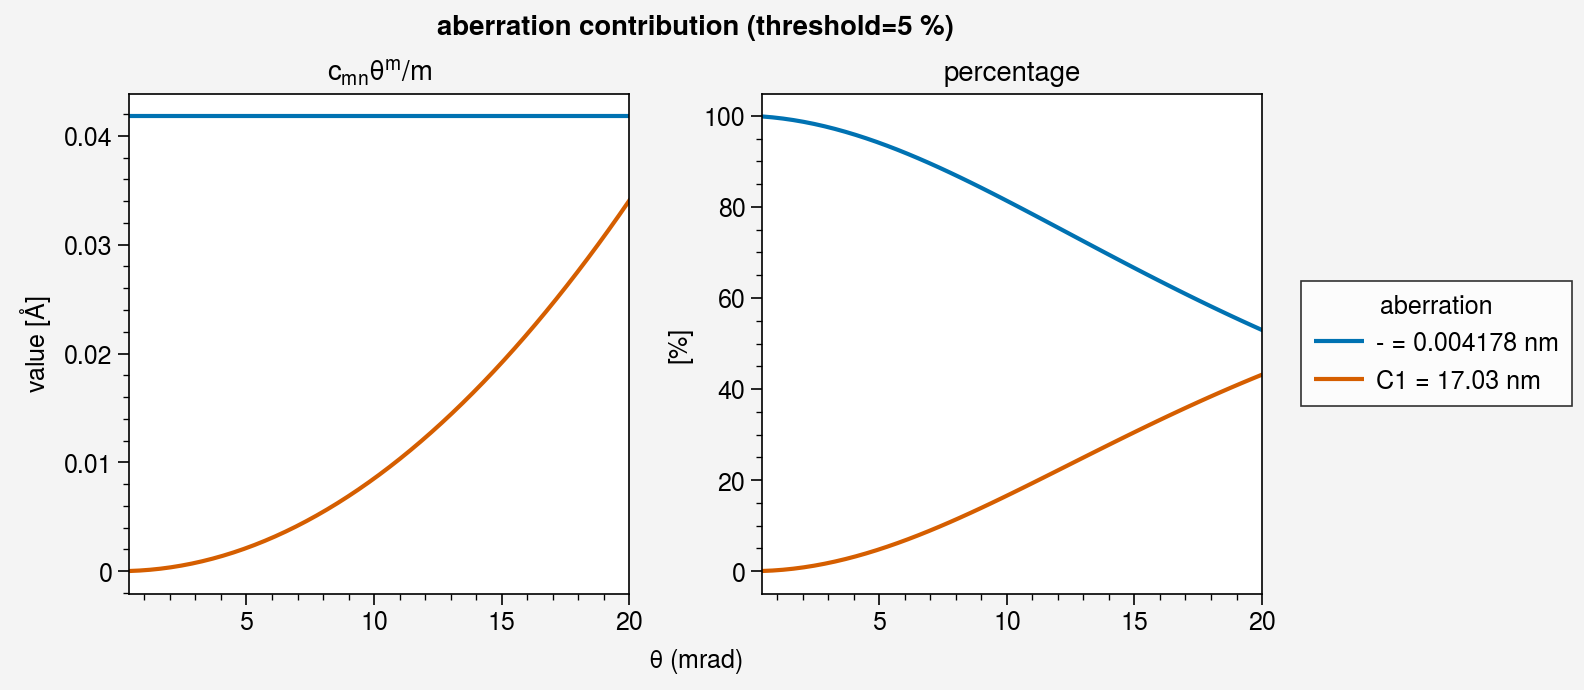

In [21]:
_ = fitaber.print_contribution(result_aber, attrs["semiconv"], threshold=5)
fitaber.plot_contribution(result_aber, attrs["semiconv"], threshold=5)

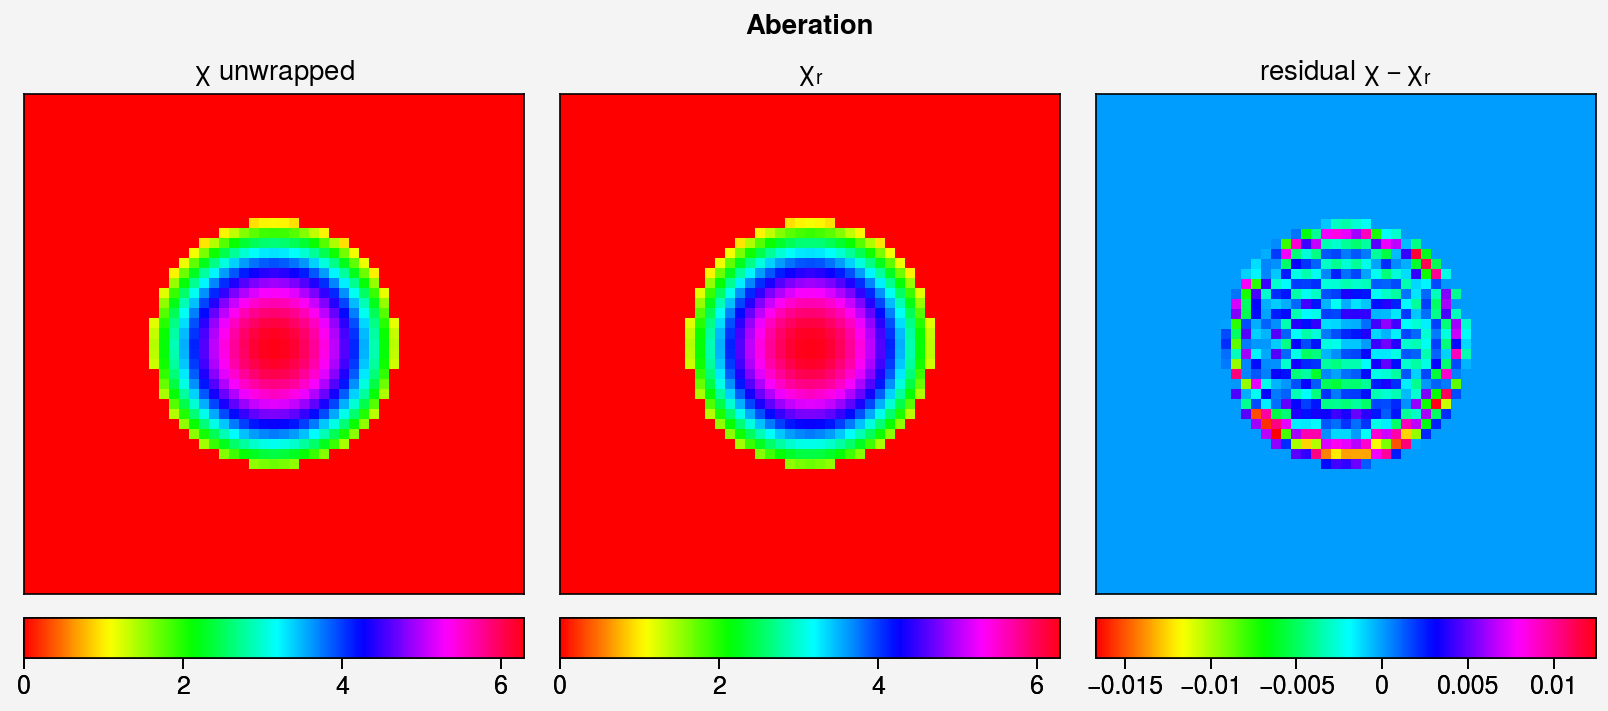

In [22]:
fig, axs = pplt.subplots(nrows=1, ncols=3, suptitle="Aberation",
                         xlim=(margin, chi.shape[1]-margin),
                         ylim=(margin, chi.shape[1]-margin),
                         xticks=[], yticks=[])
ax1, ax2, ax3 = axs

m = ax1.imshow(chi, cmap="hsv")
ax1.colorbar(m, loc="b")
ax1.format(title="$\chi$ unwrapped")

reconstaber = fitaber.aber(result_aber, chi.shape[0], resolution_reciprocal_space_rad.to('rad/pixel').m) * aperture
m = ax2.imshow(reconstaber, cmap="hsv")
ax2.colorbar(m, loc="b")
ax2.format(title="$\chi_{\mathrm{r}}$")

residual = chi - reconstaber
m = ax3.imshow(residual, cmap="hsv")
ax3.colorbar(m, loc="b")
ax3.format(title="residual $\chi - \chi_{\mathrm{r}}$")

pplt.show()